In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import sample
from mpl_toolkits.mplot3d import Axes3D

In [2]:
Mesona_K = np.array([[1.4219, 0.0005, 0.5092], 
                     [0, 1.4219, 0.3802], 
                     [0, 0, 0.0010]])*1000
Statue_K1 = np.array([[5426.566895, 0.678017, 330.096680],
                        [0.000000, 5423.133301, 648.950012],
                        [0.000000, 0.000000, 1.000000]])
Statue_K2 = np.array([[5426.566895, 0.678017, 387.430023],
                        [0.000000, 5423.133301, 620.616699],
                        [0.000000, 0.000000, 1.000000]])

In [3]:
objp = np.zeros((7*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7, 0:7].T.reshape(-1,2)
objpoints = []
imgpoints = []
img = cv2.imread('chessboard.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (7,7), None)
if ret == True:
    objpoints.append(objp)
    imgpoints.append(corners)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
our_K = mtx

In [4]:
our_K

array([[3.28154822e+03, 0.00000000e+00, 1.75658392e+03],
       [0.00000000e+00, 4.48011215e+03, 2.16925156e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [5]:
def Matcher(features1,features2):
    matches = []
    for idx1, f1 in enumerate(features1):
        f1 = np.repeat([f1], len(features2), axis = 0)
        diff = np.power((features2 - f1), 2).sum(axis = 1)
        d1, d2 = np.partition(diff, 2)[0:2]
        if d1 / d2 < 0.5:
            matches.append(cv2.DMatch(idx1, np.argmin(diff), d1))
    matches = sorted(matches, key = lambda x:x.distance)
    print("keypoint pairs: ", len(matches))
    return matches

In [6]:
def find_T(y, x):
    return np.array([[2/x, 0, -1],[0, 2/y, -1], [0, 0, 1]])

def compute_inliner(kp1, kp2, F, threshold):
    inlier_num = 0
    idxs = []
    for i in range(len(kp1)):
        error = np.abs(kp2[i].T @ F @ kp1[i])
        if error < threshold:
            inlier_num += 1
            idxs.append(i)
    return inlier_num, idxs

def Find_Fundamental_8pts(pts1, pts2):
    pts1 = pts1.T
    pts2 = pts2.T
    ones = np.ones(8, dtype = np.float)
    A = [pts1[0]*pts2[0], pts1[1]*pts2[0], pts2[0],
         pts1[0]*pts2[1], pts1[1]*pts2[1], pts2[1],
         pts1[0],         pts1[1],         ones]
    A = np.array(A).T
    _, _, v = np.linalg.svd(A)
    F = v[-1].reshape(3,3)
    u, s, v = np.linalg.svd(F)
    s[-1] = 0
    F = (u @ np.diag(s) @ v)
    F = F/F[-1,-1]
    return F


def RANSAC(kp1, kp2, T1, T2, iteration, threshold):
    F_all = []
    norm_kp1 = (T1 @ kp1.T).T
    norm_kp2 = (T2 @ kp2.T).T
    idx_list = range(len(kp1))
    for _ in range(iteration):
        sample_point1 = []
        sample_point2 = []
        for idx in sample(idx_list, 8):
            sample_point1 += [norm_kp1[idx]]
            sample_point2 += [norm_kp2[idx]]
        sample_point1 = np.array(sample_point1)
        sample_point2 = np.array(sample_point2)
        F_all.append(Find_Fundamental_8pts(sample_point1, sample_point2))

    inlier = 0
    F_norm = []
    idx_list = []
    print("scoring")
    for F in F_all:
        s, idxs = compute_inliner(norm_kp1, norm_kp2, F, threshold)
        if inlier < s:
            inlier = s
            F_norm = F
            idx_list = idxs
    print("inlier: ", inlier)
    
    #denorm
    F = T2.T @ F_norm @ T1
    F = F/F[-1,-1]
    
    return F, idx_list

In [7]:
def draw_epipolar(img1, img2, lines, pts1, pts2):
    h, w, _ = img1.shape
    for line, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        cv2.circle(img1, tuple(pt1), 5, color, -1)
        cv2.circle(img2, tuple(pt2), 5, color, -1)
        startpt = (0, int(-line[2]/line[1]))
        endpt = (w, int(-(line[0]*w + line[2])/line[1]))
        cv2.line(img2, startpt, endpt, color, 1)
    return

# Read image

In [8]:
'''
K1 = Mesona_K
K2 = Mesona_K
img1 = cv2.imread('./Mesona1.JPG')
img2 = cv2.imread('./Mesona2.JPG')
'''
'''
K1 = Statue_K1
K2 = Statue_K2
img1 = cv2.imread('./Statue1.bmp')
img2 = cv2.imread('./Statue2.bmp')
'''
K1 = our_K
K2 = our_K
img1 = cv2.imread('./our_data1.jpg')
img2 = cv2.imread('./our_data2.jpg')

# find correspondence across images

keypoint pairs:  151


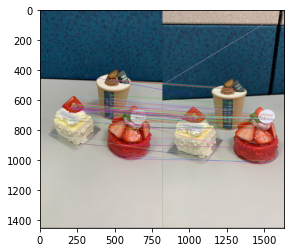

In [9]:
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
(keypoints1, features1) = sift.detectAndCompute(gray1, None)
(keypoints2, features2) = sift.detectAndCompute(gray2, None)
matches = Matcher(features1,features2)
img3 = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches[:100], img2, flags=2)
plt.imshow(img3[:,:,::-1])
plt.show()

# Estimate the fundamental matrix across images (normalized 8 points)

In [10]:
goodkp1 = np.array([list(keypoints1[x.queryIdx].pt) for x in matches], dtype = np.int32)
goodkp2 = np.array([list(keypoints2[x.trainIdx].pt) for x in matches], dtype = np.int32)
opencv_F, mask = cv2.findFundamentalMat(goodkp1,goodkp2,cv2.FM_LMEDS)
print(opencv_F)

[[-2.29769213e-06  1.58056655e-06 -1.80025511e-02]
 [-3.23136206e-06  2.63500286e-06 -2.68375688e-02]
 [ 1.86283768e-02  2.65010735e-02  1.00000000e+00]]


In [11]:
goodkp1 = np.array([list(keypoints1[x.queryIdx].pt) for x in matches], dtype = np.int32)
goodkp2 = np.array([list(keypoints2[x.trainIdx].pt) for x in matches], dtype = np.int32)
ones = np.ones((len(goodkp1), 1), dtype = np.int32)
goodkp1_3d = np.concatenate((goodkp1, ones), axis = 1)
goodkp2_3d = np.concatenate((goodkp2, ones), axis = 1)
T1 = find_T(img1.shape[0], img1.shape[1])
T2 = find_T(img2.shape[0], img2.shape[1])
F, idxs = RANSAC(goodkp1_3d, goodkp2_3d, T1, T2, 3000, 0.07)

inlier1 = goodkp1[idxs]
inlier2 = goodkp2[idxs]

print(F)

scoring
inlier:  127
[[-4.07801839e-06  3.75085737e-06 -2.11731036e-02]
 [-6.70049999e-06  4.23781440e-06 -3.01221604e-02]
 [ 2.38560235e-02  2.87390004e-02  1.00000000e+00]]


# Draw the interest points on one image and the corresponding epipolar lines in another

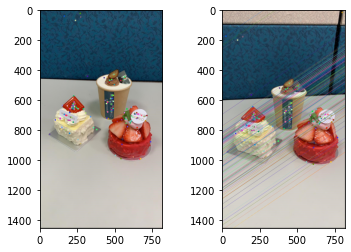

In [12]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c, _ = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

# img4 = cv2.imread('./Mesona1.JPG')
# img5 = cv2.imread('./Mesona2.JPG')
#img4 = cv2.imread('./Statue1.bmp')
#img5 = cv2.imread('./Statue2.bmp')
img4 = cv2.imread('./our_data1.jpg')
img5 = cv2.imread('./our_data2.jpg')

goodkp1 = goodkp1.astype(int)
goodkp2 = goodkp2.astype(int)
# Find epilines corresponding to points in left image (first image) and drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(goodkp1.reshape(-1,1,2), 1, opencv_F)
lines2 = lines2.reshape(-1,3)
drawlines(img5,img4,lines2,goodkp2,goodkp1)
plt.subplot(121),plt.imshow(img4[:,:,::-1])
plt.subplot(122),plt.imshow(img5[:,:,::-1])
plt.show()

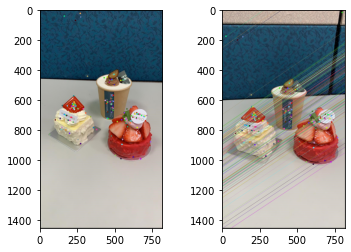

In [13]:
# img4 = cv2.imread('./Mesona1.JPG')
# img5 = cv2.imread('./Mesona2.JPG')
#img4 = cv2.imread('./Statue1.bmp')
#img5 = cv2.imread('./Statue2.bmp')
img4 = cv2.imread('./our_data1.jpg')
img5 = cv2.imread('./our_data2.jpg')

lines = []
for kp in goodkp1_3d:
    lines.append(F @ (kp.T))
draw_epipolar(img4, img5, lines, goodkp1, goodkp2)
plt.subplot(121),plt.imshow(img4[:, :, ::-1])
plt.subplot(122),plt.imshow(img5[:,:,::-1])
plt.show()

# Get 4 possible solutions of essential matrix from fundamental matrix

In [14]:
#find out the most appropriate solution of essential matrix
E = K1.T @ F @ K2
U, S, Vt = np.linalg.svd(E)
m = (S[0] + S[1])/2
E = U @ [[m, 0, 0], [0, m, 0], [0, 0, 0]] @ Vt
# U, S, Vt = np.linalg.svd(E)
W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
# if np.linalg.det(U@Vt):
#     Vt = -Vt
    
EX1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
R1 =  U @ W.T @ Vt
R2 =  U @ W @ Vt
u3 = U[:,2:]

EX2_list = []
EX2_list.append(np.hstack((R1, u3)))
EX2_list.append(np.hstack((R1, -u3)))
EX2_list.append(np.hstack((R2, u3)))
EX2_list.append(np.hstack((R2, -u3)))

In [15]:
#apply triangulation to get 3D points
def triangulation(x1, x2, K1, K2, EX1, EX2):
    u1, v1 = x1
    u2, v2 = x2
    P1 = K1 @ EX1
    P2 = K2 @ EX2
    P11, P12, P13 = P1
    P21, P22, P23 = P2
    
    A = np.zeros((4, 4))
    A[0] = u1*P13 - P11
    A[1] = v1*P13 - P12
    A[2] = u2*P23 - P21
    A[3] = v2*P23 - P22
    
    U, S, Vt = np.linalg.svd(A)
    point = (Vt[-1]/Vt[-1, -1])[:3]
    
    return point

    
points_list = []
for EX2 in EX2_list:
    points = []
    for i in range(len(inlier1)):
        points.append(triangulation(inlier1[i], inlier2[i], K1, K2, EX1, EX2))
    points_list.append(points)
points_list = np.array(points_list)


In [16]:
def front_pts(K, EX, points):
    R = EX[:, :3]
    t = EX[:, 3]
    C = -R.T @ t
    num = 0
    for i in points:
        if np.dot((i - C), R[2, :].T) > 0:
            num += 1
    return num

front_num = []
for i in range(4):
    front_num.append(front_pts(K2, EX2_list[i], points_list[i]))
print(front_num)
best_EX2 = np.argmax(front_num)
print(best_EX2)
    

[0, 127, 127, 0]
1


(127, 3)


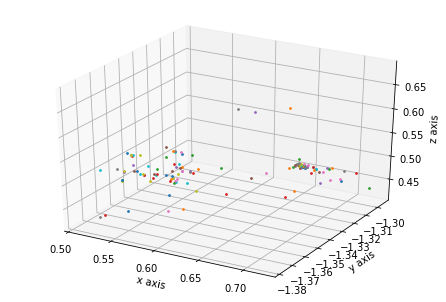

In [17]:
def plot(_3d):
    fig = plt.figure()
    ax = Axes3D(fig)
    for i in range(_3d.shape[0]):
        ax.scatter(_3d[i, 0], _3d[i, 1], _3d[i, 2], s = 3)
    #ax.plot(final3d[:, 0], final3d[:, 1], final3d[:, 2], 'b.')
    ax.set_xlabel('x axis')
    ax.set_ylabel('y axis')
    ax.set_zlabel('z axis')
    #ax.view_init(elev = 0, azim = 0)
    plt.show()

best_3dp = np.zeros(points_list[best_EX2].shape)
for i in range(best_3dp.shape[0]):
    best_3dp[i] = np.array([points_list[best_EX2][i][0], points_list[best_EX2][i][2], points_list[best_EX2][i][1]])


print(best_3dp.shape)
plot(best_3dp)

In [18]:
import matlab.engine
import matlab
eng = matlab.engine.start_matlab()
_3d = matlab.double(best_3dp.tolist())
P = matlab.double((K1 @ EX1).tolist())
_2d = matlab.double(np.array(inlier1).tolist())
eng.obj_main(_3d, _2d, P, 'our_data1.jpg', 1, nargout=0)
eng.quit()